In [1]:
pip install langgraph

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install langsmith langchain_groq langchain_community

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [3]:
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper)


In [4]:
wiki_tool.invoke("who is the current president of India")

'Page: List of presidents of India\nSummary: The president of India is the head of state of the Republic of India and the Supreme Commander of the Indian Armed Forces. The president is referred to as the first citizen of India. Although vested with these powers by the Constitution of India, the positi'

In [5]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [6]:
tools=[wiki_tool]

In [7]:
# from langgraph.graph.message import add_messages
# class State(TypedDict):
#     messages:Annotated[list,add_messages]

## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [8]:
from langgraph.graph import StateGraph,START,END

In [9]:
graph_builder=StateGraph(State)

In [10]:
from langchain_groq import ChatGroq
groq_api_key='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'

In [11]:
llm=ChatGroq(model_name="mixtral-8x7b-32768",groq_api_key=groq_api_key)

In [12]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FC7EC70CB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FC7BF20E00>, groq_api_key=SecretStr('**********'))

In [13]:
llm_with_tools=llm.bind_tools(tools=tools)

In [14]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
# def chatbot(state:State):
#   return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [15]:
from langgraph.prebuilt import ToolNode,tools_condition

In [16]:
# graph_builder.add_node("chatbot",chatbot)
# # 
# tool_node=ToolNode(tools=tools)
# graph_builder.add_node("tools",tool_node)

# graph_builder.add_conditional_edges(
#     "chatbot",
#     tools_condition,
#     )
# graph_builder.add_edge("tools","chatbot")
# graph_builder.add_edge(START,"chatbot")
# # graph_builder.add_edge("chatbot",END)

graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [17]:
graph_builder.compile()

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x000001FC7B777290>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:chatbot>(recurse=True, writes=[ChannelWriteEntry(channel='start:chatbot', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'chatbot': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages'}, triggers=['tools', 'start:chatbot'], mapper=functools.partial(<function _coerce_state at 0x000001FC7E69B880>, <class '__main__.State'>), writers=[ChannelWrite<chatbot,messages>(recurse=True, writes=[ChannelWriteEntry(channel='chatbot', value='chatbot', skip_none=False, mapper=None), ChannelWriteEntry(c

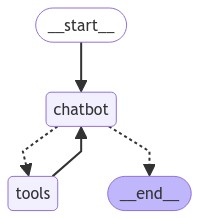

In [18]:
graph=graph_builder.compile()
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
user_input="hii there, My name is vinay"
events=graph.stream(
    {"messages":[("user",user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hii there, My name is vinay
================================== Ai Message ==================================

Hello Vinay, nice to meet you! Based on the information you've provided, I don't see a need to use any tools at the moment. If you have any questions or need assistance with something, feel free to ask!


In [20]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================

RLHF stands for Reinforcement Learning with Human Feedback. It is a machine learning technique that utilizes human input to train AI models. The AI system learns from the rewards and punishments provided by humans to improve its behavior and decision-making abilities. This method can help create AI models that better align with human values and expectations. The 'wikipedia' tool can be used to get more information about RLHF, by providing "Reinforcement Learning with Human Feedback" as the 'query' parameter value.
